In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

In [3]:
import pandas as pd
df = pd.read_csv('../Dataset/train.csv')

In [4]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [5]:
# df[(df['Response'] == 1) & (df['Previously_Insured'] == 1)]
# df.query("Response == 1 and Previously_Insured == 1")

# Response trends over different features

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64
Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Previously_Insured
0    206481
1    174628
Name: count, dtype: int64


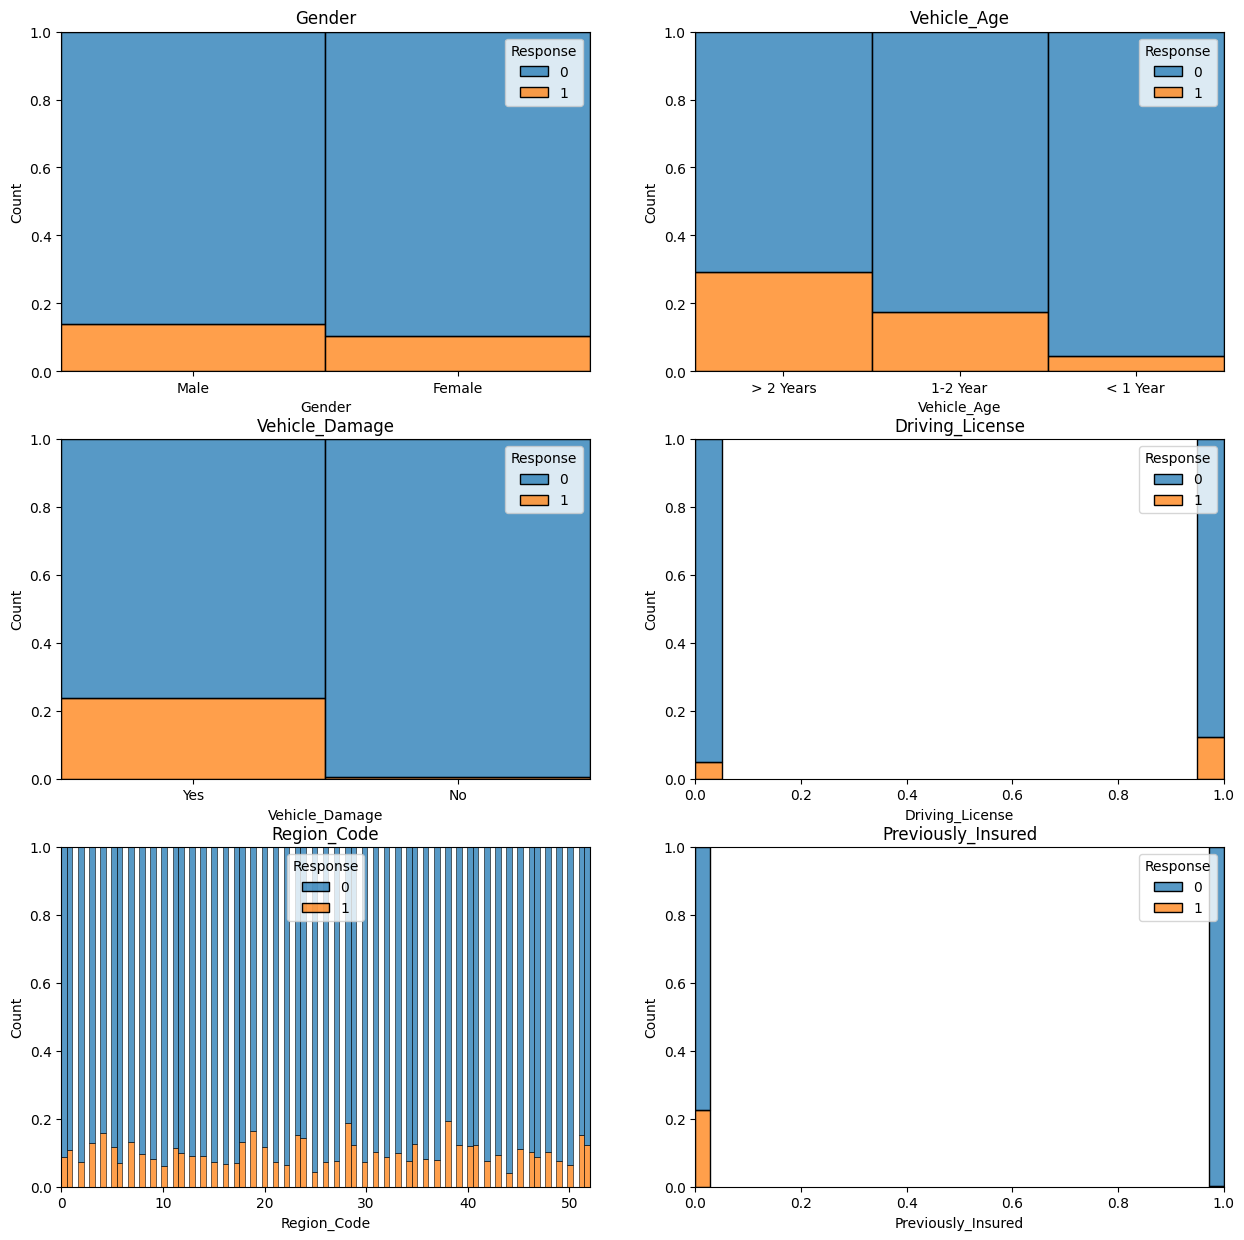

In [6]:
xes = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Region_Code', 'Previously_Insured']

for x in xes:
    if x != 'Region_Code':
        print(df[x].value_counts())

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for x, axis in zip(xes, axes.flat):
    sns.histplot(data=df, x=x, hue='Response', multiple='fill', ax=axis, palette=["C0", "C1"])
    axis.set_title(x)

### Gender

More men are taking the insurance than women. This is evident from the histogram above which compares the percentage of men and women who took the insurance.

About 17% of men took the insurance whereas only around 14% of women bought it.

**But this difference is not significant.**

### Vehicle_Age

From the above histogram, we can see as the age of the car increases, more people start buying the insurance. This might seem counter-intuitive to the belief that people buy insurance for recently bought vehicles.

**However, since the data is highly imbalanced, where we have very few data points for older cars, we cannot necessarily mark this as a trend in the data.**

### Vehicle_Damage

**More people buy insurance who have at some point damaged their vehicles. Almost no one buys insurance if they don't have a single incident of vehicle damage.**

### Driving_License

People who have a driver's license often tend to buy the insurance for their vehicle as well. Difference in people who have and don't have a driving license who buy an insurance is almost double.

**Since the data is highly imbalanced, having very few data points for people with no driver's license, this may not be the correct pattern.**

### Region_Code

There is no significant change in responses over all region codes. Thus nothing significant can be inferred from this.


### Previously Insured

**People who were previously not insured are buying more than people who already had insurance.**

### Data Proportion in Vehicle_Age and Driving_License to prove above findings

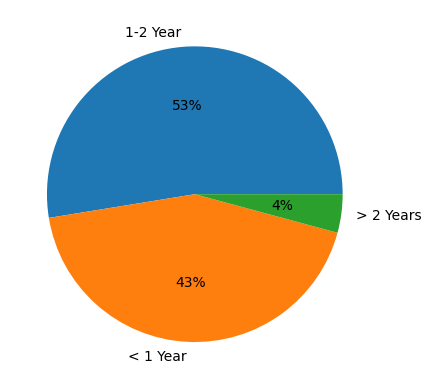

In [7]:
pie_series = df['Vehicle_Age'].value_counts()
plt.pie(x = pie_series, labels=pie_series.index, autopct='%.0f%%')
plt.show()

This shows that data is highly imbalanced towards newer vehicles.

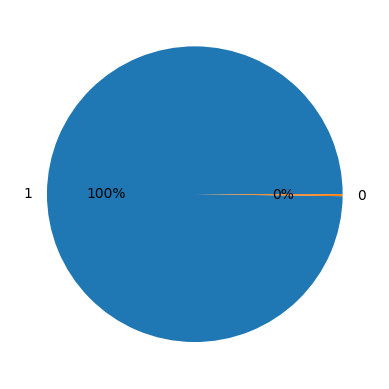

In [8]:
pie_series = df['Driving_License'].value_counts()
plt.pie(x = pie_series, labels=pie_series.index, autopct='%.0f%%')
plt.show()

**Note:** There are negligibly less data for customers without driver's license in our dataset which shows a significant imbalance data, thus making any assumptions regarding the impact of Driver's License on Response can be considered inaccurate.

<Axes: xlabel='Age', ylabel='Count'>

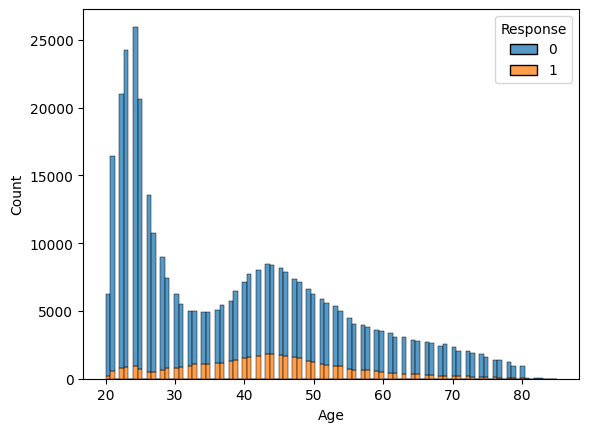

In [9]:
sns.histplot(data=df, x='Age', hue='Response', multiple='stack', palette=["C0", "C1"], kde = False)

Middle and old aged (Generally people of age 30 and above) people tend to buy the insurance more than relatively younger customers.

## Data Transformation

In [10]:
# Will use data instead of df from here
data = df.copy()

# Binary Data Encoding
data['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
data['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Ordinal Data Encoding
data['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


<Axes: title={'center': 'Correlation Plot'}>

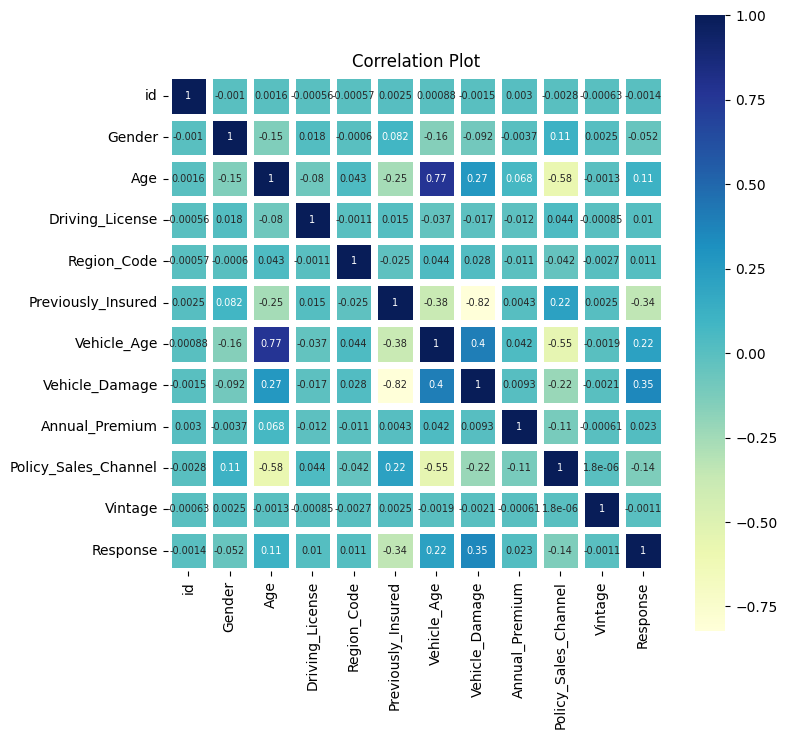

In [11]:
plt.figure(figsize=(8,8))
plt.title("Correlation Plot")
sns.heatmap(data.corr(),linewidths=5, annot=True, square=True,annot_kws={'size': 7},cmap='YlGnBu')

## Balancing the data

### Response distribution in our original dataset

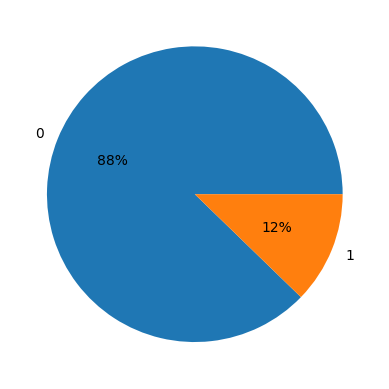

In [12]:
response_series = data['Response'].value_counts()
plt.pie(x = response_series, labels=response_series.index, autopct='%.0f%%')
plt.show()

**Since there are a lot less examples for Response = 1, any machine learning model would not be able to fare good in learning the underlying patterns for this kind of input. Thus we need to synthesize the data for Response = 1 so as to facilitate our machine learning model with a balanced dataset to learn from.**

In [13]:
X = data.drop(['Response', 'id'], axis = 1)
y = data[['Response']]


In [14]:
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, y)
print(y.value_counts())
print()
print(y_smote.value_counts())

Response
0           334399
1            46710
Name: count, dtype: int64

Response
0           334399
1           334399
Name: count, dtype: int64


### Response distribution after SMOTE

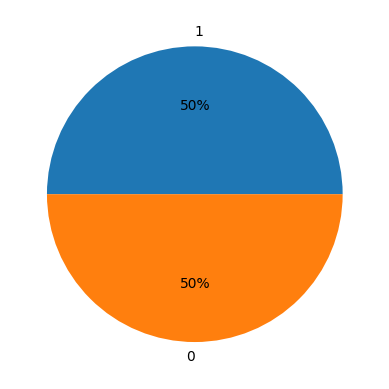

In [15]:
new_response_series = y_smote['Response'].value_counts()
plt.pie(x = new_response_series, labels=new_response_series.index, autopct='%.0f%%')
plt.show()

## Model Evaluation

In [16]:
test_data = pd.read_csv('../Dataset/test.csv')

X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size= 0.3, random_state=1)

models = {
    'LogisticRegression' : make_pipeline(LogisticRegression()),
    'DecisionTreeClassifier': make_pipeline(DecisionTreeClassifier()),
    'RandomForestClassifier': make_pipeline(RandomForestClassifier()),
    'GradientBoost': make_pipeline(GradientBoostingClassifier(n_estimators = 200, random_state = 1)),
    'AdaBoost': make_pipeline(AdaBoostClassifier(n_estimators= 150, random_state= 1)),
    'XGBoost': make_pipeline(xgb.XGBClassifier(objective="binary:logistic", random_state=1, eval_metric="auc"))
}

model_results = {}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

for model_name in models:
    model = models[model_name]
    results = cross_validate(model, X_train, y_train, scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'], cv = cv, verbose=False)
    print(model_name)
    
    model_results[model_name] = pd.DataFrame(results)

LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
GradientBoost
AdaBoost
XGBoost


In [17]:
mean_results = pd.DataFrame(columns = [
    'LogisticRegression',
    'DecisionTreeClassifier',
    'RandomForestClassifier'
    'GradientBoost',
    'AdaBoost',
    'XGBoost'
])

for model_name in models:
    mean_results[model_name] = model_results[model_name].mean()
    
mean_results.dropna(axis=1, inplace=True)

mean_results

,LogisticRegression,DecisionTreeClassifier,AdaBoost,XGBoost,RandomForestClassifier,GradientBoost
fit_time,2.225315,2.353152,37.155834,1.972151,65.624884,96.538215
score_time,0.197744,0.210308,2.479696,0.412513,5.399866,0.628903
test_precision,0.683377,0.862968,0.793846,0.845915,0.862857,0.819394
test_recall,0.745680,0.879459,0.923067,0.896214,0.904706,0.920543
test_f1,0.710934,0.871134,0.853594,0.870336,0.883285,0.867028
test_balanced_accuracy,0.705317,0.869873,0.841629,0.866445,0.880424,0.858779
test_roc_auc,0.762867,0.869992,0.926144,0.953453,0.959490,0.947453


**From the above results, it is evident that Random Forest Classifier and XG Boost models output the best ROC_AUC. Let's predict on the test data to see which yields the better ROC_AUC in case of test data.**

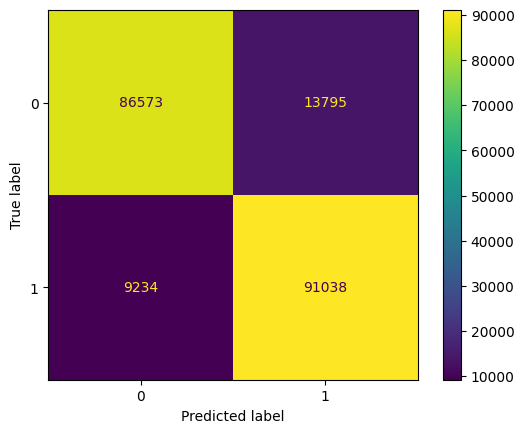

In [18]:
dtc = models['RandomForestClassifier']
dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)

rf_test_prob = dtc.predict_proba(X_test)[:, 1]
rf_roc_auc_score = roc_auc_score(y_test, rf_test_prob)

Cmatrix = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = Cmatrix, display_labels = [0, 1])
cm_display.plot()

In [19]:
print("Classification Resport (Random Forest Classifier)\n------------------------------------------------------------")
print(classification_report(y_test, preds))

Classification Resport (Random Forest Classifier)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88    100368
           1       0.87      0.91      0.89    100272

    accuracy                           0.89    200640
   macro avg       0.89      0.89      0.89    200640
weighted avg       0.89      0.89      0.89    200640



In [20]:
print(f'ROC AUC of Random Forest = {rf_roc_auc_score}')

ROC AUC of Random Forest = 0.9626362765758406


#### ROC Curve for Random Forest Classifier

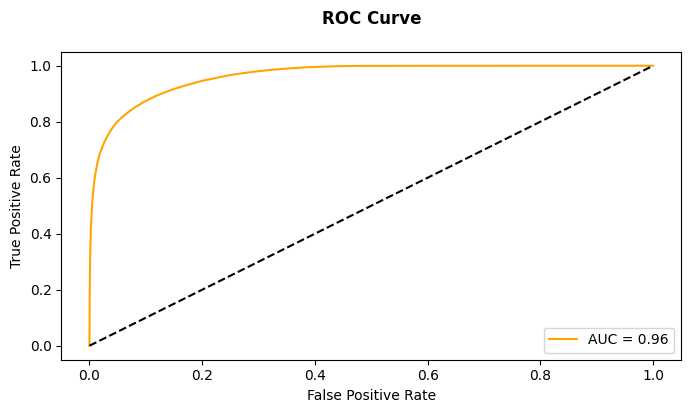

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, rf_test_prob)
auc = roc_auc_score(y_test, rf_test_prob)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

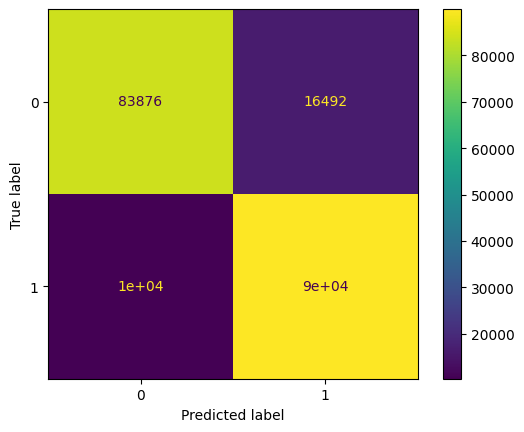

In [22]:
xg_model = models['XGBoost']
xg_model.fit(X_train, y_train)
xg_preds = xg_model.predict(X_test)


Cmatrix = confusion_matrix(y_test, xg_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = Cmatrix, display_labels = [0, 1])
cm_display.plot()

In [23]:
print("Classification Resport (Random Forest Classifier)\n------------------------------------------------------------")
print(classification_report(y_test, xg_preds))

Classification Resport (Random Forest Classifier)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.86    100368
           1       0.85      0.90      0.87    100272

    accuracy                           0.87    200640
   macro avg       0.87      0.87      0.87    200640
weighted avg       0.87      0.87      0.87    200640



In [24]:
xg_test_prob = xg_model.predict_proba(X_test)[:, 1]
xg_roc_auc_score = roc_auc_score(y_test, xg_test_prob)

print(f'ROC AUC of XGBoost = {xg_roc_auc_score}')

ROC AUC of XGBoost = 0.9537377168292425


### ROC AUC Curve for XGBoost

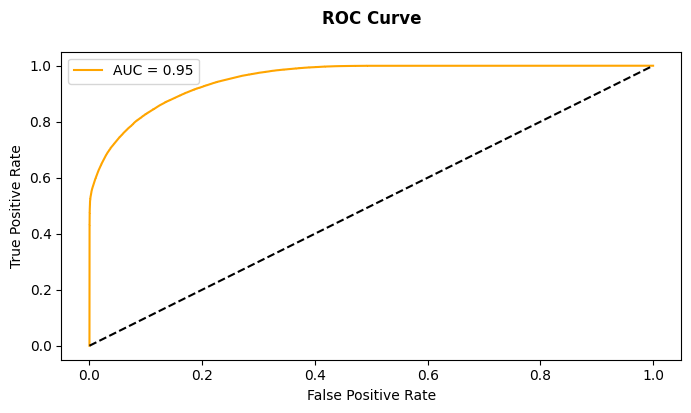

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, xg_test_prob)
auc = roc_auc_score(y_test, xg_test_prob)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## Results
**Comparing the above results suggests that model with best ROC_AUC is "Random Forest Classifier" having ROC_AUC = 96.23%**

## Expected Value Framework

Let's say that a company who was previously offering health insurance to its clients is now also offering Vehicle insurance to its customers. Thus the company wants to predict the customers who'll be willing to buy the insurance from the company given the historical data if health insured customers.

**Business Assumptions:**

Top insurance companies spend huge chunks of money on advertising and marketing their services to potential clients. Gathering the stats from the internet, we can assume a top company spends around 10-20 Billion dollars on marketing. The companies spend so much of money on advertisement so as to attract the customers to purchase their services. An average gross revenue of some of the biggest insurance companies could lie anywhere from 50 Billion dollars to more than a 100 Billion dollars. Assuming the customer base of these companies is around 1.5-2 Billion, the average cost of advertisement and marketing comes around $10 per person (considering the upper bound). The average income from each client gained will be around $45 per person. If the company fails to attract the customers through these advertisements, there will still be expenditure of marketing for that person which is about $10 per head. Again, if the company falsely predicts a customer won't buy the insurance and thus doesn't advertise it to that customer, it will lead to loss of potential customers, considered as the Opportunity Cost, which let's say is around $30/person.

**Thus our Cost & Benefits matrix would look something like--->**

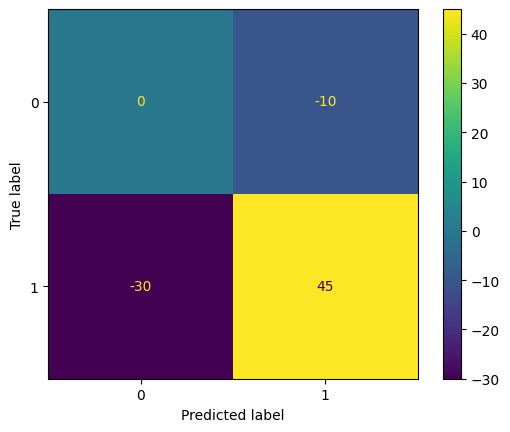

In [33]:
cost_benefit_matrix = np.array([[0, -10], [-30, 45]])

c_and_b = ConfusionMatrixDisplay(confusion_matrix = cost_benefit_matrix, display_labels = [0, 1])
c_and_b.plot()

### Calculating EVF for XGBoost

Text(0.5, 1.0, 'XGBoost Prediction Probabilities')

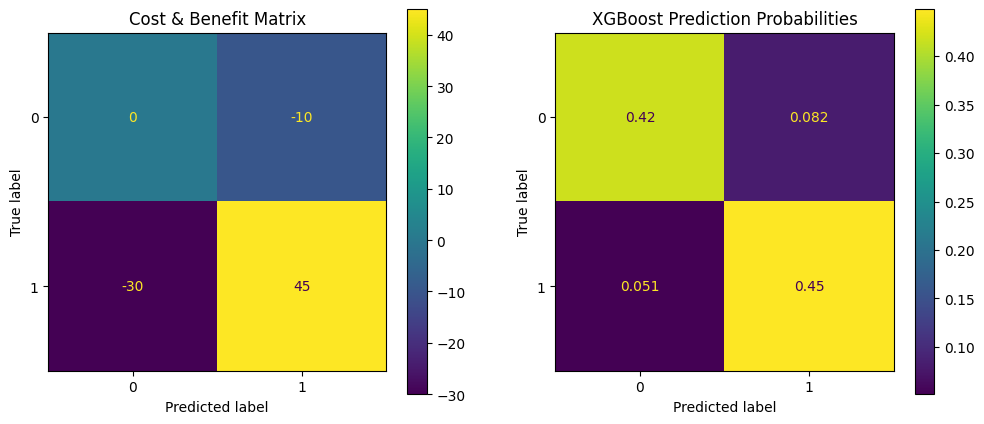

In [34]:
new_xg_Cmatrix = confusion_matrix(y_test, xg_preds, normalize = 'all')
xg_prob = ConfusionMatrixDisplay(confusion_matrix = new_xg_Cmatrix, display_labels = [0, 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

c_and_b.plot(ax=ax1)
xg_prob.plot(ax=ax2)

ax1.set_title("Cost & Benefit Matrix")
ax2.set_title("XGBoost Prediction Probabilities")

#### Multiplying above two matrix and summing up gives us

**EVF for XGBoost = $17.90 (Profit per person)**

### Calculating EVF for Random Forest Classifier

Text(0.5, 1.0, 'Random Forest Prediction Probabilities')

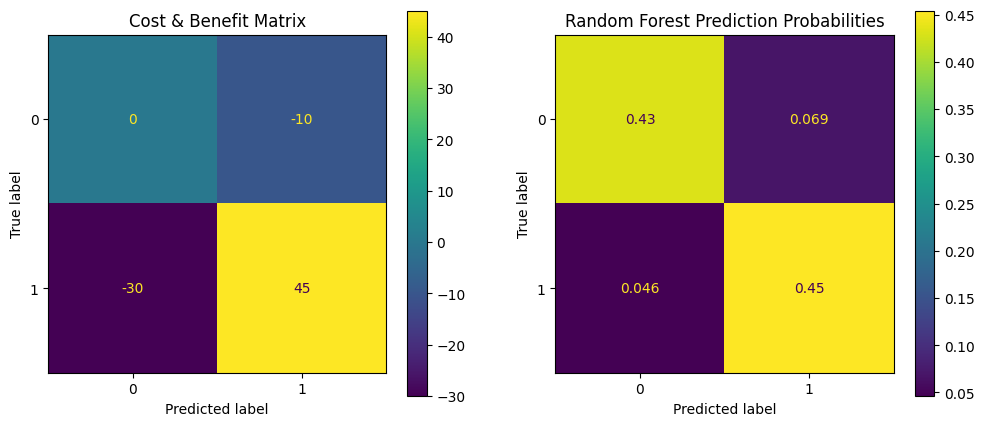

In [35]:
new_rdf_Cmatrix = confusion_matrix(y_test, preds, normalize = 'all')
rdf_prob = ConfusionMatrixDisplay(confusion_matrix = new_rdf_Cmatrix, display_labels = [0, 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

c_and_b.plot(ax=ax1)
rdf_prob.plot(ax=ax2)

ax1.set_title("Cost & Benefit Matrix")
ax2.set_title("Random Forest Prediction Probabilities")

#### Multiplying above two matrix and summing up gives us

**EVF for Random Forest = $18.18 (Profit per person)**

## Random Prediction

Randomly predicting clients to advertise insurance to will give equal probabilities predicting correctly and incorrectly.

This will give us the following probality matrix

[
    
    [0.25,    0.25],

    [0.25,    0.25]

]

Text(0.5, 1.0, 'Random Prediction Probabilities')

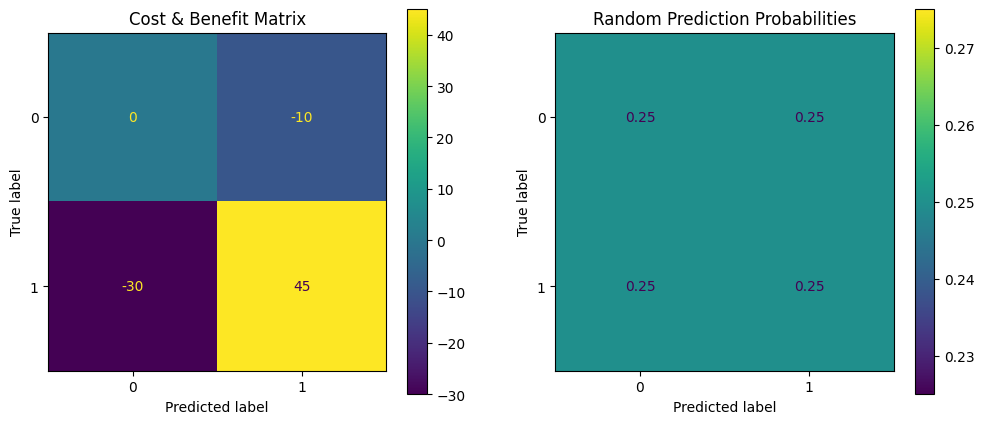

In [36]:
random_probabilities = np.array([[0.25, 0.25], [0.25, 0.25]])

random_prob = ConfusionMatrixDisplay(confusion_matrix = random_probabilities, display_labels = [0, 1])


new_rdf_Cmatrix = confusion_matrix(y_test, preds, normalize = 'all')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

c_and_b.plot(ax=ax1)
random_prob.plot(ax = ax2)


ax1.set_title("Cost & Benefit Matrix")
ax2.set_title("Random Prediction Probabilities")

#### Multiplying above two matrix and summing up gives us

**EVF for Random Predictions = $2.25 (Profit per person)**

## Conclusion

**Random Forest Classifier fares better than XGBoost and Random Prediction Model to maximize the Expected Value Framework, therefore using Random Forest Classifier to predict whether the customers will buy the insurance or not will lead to higher profits for the company.**

**Assuming the company serves to 1 million clients:**

Random Prediction Profit = 1000000 * 2.25 = $22,50,000

XGBoost Profit = 1000000 * 17.90 = $17,900,000

Random Forest Profit = 1000000 * 18.18 = $18,180,000


Using Random Forest over Predicting the prospective clients randomly will lead to an increase in company's profit by around **16 Million Dollars.**